#  과제1. 수어 번역기 파이프라인

* 데이터 출처 : https://www.kaggle.com/datasets/datamunge/sign-language-mnist?select=sign_mnist_train

## 1.환경준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import cv2
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

np.set_printoptions(linewidth=np.inf)

In [2]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

In [3]:
path = ''
file = 'sign_language.csv'

data = pd.read_csv(path+file)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [4]:
data.shape

(8000, 785)

### (3) class names
* label이 0 ~ 27 까지의 숫자로 표현됩니다.
* 수어 중에서 J(9) 와 Z(27)는 손을 움직이면서 표현해야 하므로, 여기서는 제외합니다.
* 숫자로 레이블링 된 것을, 나중에 문자 변환하기 위해 문자로 된 리스트를 생성합니다.

In [5]:
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

(26,
 array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1'))

In [6]:
class_names[24]

'y'

## 2 데이터 살펴보기

### (1) 데이터 한 건을 2차원으로 변환하고 그림 그리기

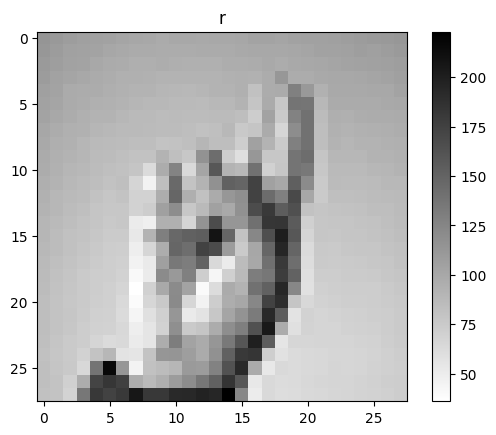

In [17]:
# 아래 숫자를 바꿔가며 화면에 그려 봅시다.
n = 100
sign_fig = data.iloc[n, 1:].values
sign_fig = sign_fig.reshape(28, 28)

sign = class_names[data.iloc[n,0]]

plt.title(sign)
plt.imshow(255-sign_fig, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

## 3.데이터 준비

* 주어진 데이터셋
    * 2차원 데이터셋, 1차원 데이터포인트(분석단위, 예측단위) 입니다. 
    * 흑백 이미지데이터
    * 이 데이터로부터 데이터 준비작업을 수행합니다.
        * 데이터 분할1 : x, y
        * 데이터 분할2 : train, validation
        * 만약 CNN으로 모델링을 한다면, shape를 맞춰야 합니다. (n, 28, 28, 1) 
        * scaling
* 그러나 운영에서 발생될 데이터는 이미지 한장 한장 입니다. 이미지 한장, 한장 들어온다면 어떻게 데이터가 처리되어야 할까요?(Data Pipeline 구성)

### (1) 데이터 분할1 : x, y 나누기

In [7]:
x=data.drop("label",axis=1)
y=data["label"]

In [19]:
len(y.unique())

24

### (2) 데이터 분할2 : train, validation

* train : val : test = 5000 : 2000 : 1000
* 여기서 test set은 파이프라인 점검을 위한 용도로 사용합니다.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=1000,random_state=42,stratify=y)

In [9]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=2000,random_state=42,stratify=y_train)

In [10]:
# 모두 넘파이로 변환
x_train=np.array(x_train)
y_train=np.array(y_train)
x_val=np.array(x_val)
y_val=np.array(y_val)
x_test=np.array(x_test)
y_test=np.array(y_test)

### (3) shape 맞추기 n, 28,28,1

* reshape
    * x_train.shape : (-1, 28, 28, 1)
    * x_val.shape : (-1, 28, 28, 1)

In [11]:
x_train=x_train.reshape(-1,28,28,1)

In [12]:
x_val=x_val.reshape(-1,28,28,1)

### (4) Scaling : Min-Max

* 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
* x_train, x_test를 그냥 255로 나누면 됨

In [13]:
x_train=x_train/255
x_val=x_val/255

## 4.모델링

### (1) 모델 설계

In [26]:
keras.backend.clear_session()

il = keras.layers.Input(shape=(28,28,1))
cl = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same",activation="relu")(il)
bl = keras.layers.BatchNormalization()(cl)
cl2 = keras.layers.Conv2D(filters=32,kernel_size=(2,2),padding="valid",activation="relu")(bl)
bl2 = keras.layers.BatchNormalization()(cl2)
cl3 = keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu")(bl2)
bl3 = keras.layers.BatchNormalization()(cl3)
pl = keras.layers.MaxPool2D(pool_size=(2,2))(bl3)
cl4 = keras.layers.Conv2D(filters=80,kernel_size=(3,3),padding="same",activation="relu")(pl)
bl4 = keras.layers.BatchNormalization()(cl4)
cl5 = keras.layers.Conv2D(filters=192,kernel_size=(2,2),padding="valid",activation="relu")(bl4)
pl2 = keras.layers.MaxPool2D(pool_size=(2,2))(cl5)

a = keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu")(pl2)
a2 = keras.layers.BatchNormalization()(a)
a3 = keras.layers.Conv2D(filters=96,kernel_size=(3,3),padding="same",activation="relu")(a2)
a4 = keras.layers.BatchNormalization()(a3)
a5 = keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu")(a4)
a6 = keras.layers.BatchNormalization()(a5)

b = keras.layers.Conv2D(filters=48,kernel_size=(3,3),padding="same",activation="relu")(pl2)
b2 = keras.layers.BatchNormalization()(b)
b3 = keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu")(b2)
b4 = keras.layers.BatchNormalization()(b3)

c = keras.layers.AveragePooling2D(pool_size=(2,2),strides=(1,1),padding="same")(pl2)
c2 = keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu")(c)
c3 = keras.layers.BatchNormalization()(c2)

d = keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu")(pl2)
d2 = keras.layers.BatchNormalization()(d)

Add = keras.layers.Add()([a6,b4,c3,d2])
con = keras.layers.Concatenate()([a6,b4,c3,d2])

con2 = keras.layers.Concatenate()([Add,con])

aver = keras.layers.GlobalAveragePooling2D()(con2)

ol = keras.layers.Dense(26,activation = "softmax")(aver)



model = keras.models.Model(il,ol)
model.compile(loss=keras.losses.sparse_categorical_crossentropy,metrics=["accuracy"],optimizer="adam")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   160         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 13, 13, 32)   4128        ['batch_normalization[0][0]']

### (2) 학습

In [27]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = "val_loss",
                   min_delta=0,
                   patience = 5,
                   verbose=1,
                   restore_best_weights=True)
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),verbose=1,epochs=30,callbacks=[es])

Epoch 1/30
157/157 [==============================] - 9s 37ms/step - loss: 0.7350 - accuracy: 0.7928 - val_loss: 3.4901 - val_accuracy: 0.0725
Epoch 2/30
157/157 [==============================] - 5s 34ms/step - loss: 0.0479 - accuracy: 0.9914 - val_loss: 2.8872 - val_accuracy: 0.1795
Epoch 3/30
157/157 [==============================] - 5s 33ms/step - loss: 0.0331 - accuracy: 0.9924 - val_loss: 1.0411 - val_accuracy: 0.6755
Epoch 4/30
157/157 [==============================] - 5s 33ms/step - loss: 0.0090 - accuracy: 0.9986 - val_loss: 0.0154 - val_accuracy: 0.9965
Epoch 5/30
157/157 [==============================] - 5s 33ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0086 - val_accuracy: 0.9970
Epoch 6/30
157/157 [==============================] - 5s 33ms/step - loss: 5.2568e-04 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9980
Epoch 7/30
157/157 [==============================] - 5s 33ms/step - loss: 3.7005e-04 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy

### (3) 학습결과 그래프

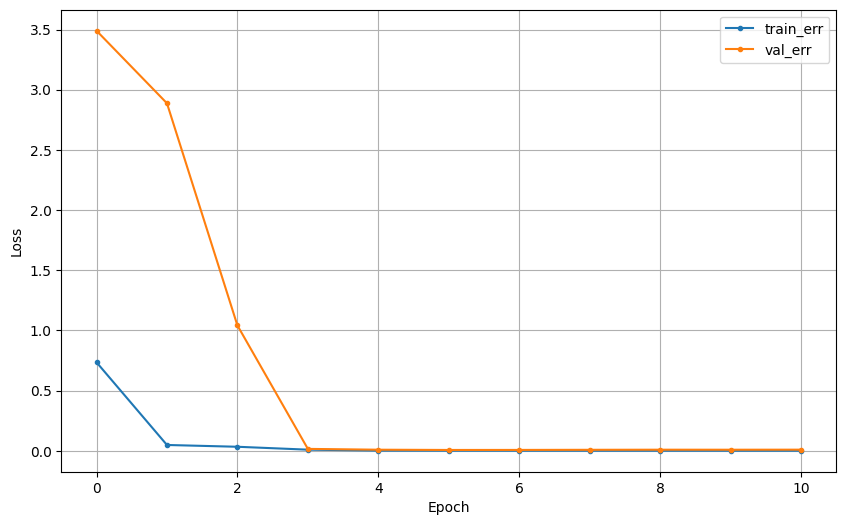

In [28]:
dl_history_plot(history.history)

### (4) 예측 및 검증

## 5.저장하기

* 여기서는 joblib을 이용하여 모델과 데이터셋을 저장하겠습니다.

### (1) 모델 저장하기

In [44]:
joblib.dump(model,'model2.pkl')

['model2.pkl']

### (2) 모델 로딩하기
* 로딩시 model2로 저장합니다.

In [14]:
model2 = joblib.load('model2.pkl')

### (3) test 셋으로 예측하고 평가해보기

* test 셋에 필요한 전처리는 다음과 같습니다.
    * 넘파이 어레이로 변환
    * 4차원 데이터셋으로 변환
    * 스케일링

In [15]:
# 넘파이 어레이로 변환
x_test = np.array(x_test)
y_test = np.array(y_test)

# 4차원 데이터셋
x_test = x_test.reshape(-1,28,28,1)

# 스케일링
x_test = x_test/255

In [32]:
# 예측하고 평가하기
y_pred = model2.predict(x_test)


32/32 [==============================] - 1s 11ms/step


In [33]:
y_pred_ = y_pred.argmax(axis=1)

In [34]:
accuracy_score(y_test,y_pred_)
confusion_matrix(y_test,y_pred_)

array([[42,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 43,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 34,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 45,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 43,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 41,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 42,  0,  0,

## 6.Data Pipeline 구성

### (1) 라이브러리 로딩

In [35]:
# 파이프라인에서 필요한 라이브러리/함수
import pandas as pd
import numpy as np
import cv2
import joblib

### (2) 테스트 데이터 로딩
* 제공받은 이미지로 테스트 해보기
* 직접 찍은 사진으로 테스트 해보기

In [36]:
# 파일 열기
path = 'test image/'
file = 'v.png'
filename = path + file

img = cv2.imread(filename)
cv2.imshow('img', img)

cv2.waitKey(0) # 키보드 입력 대기
cv2.destroyAllWindows() # 키보드 입력이 있으면 이미지 창 닫기

#### 1)이미지 읽을 때 흑백으로 읽기

In [37]:
# 파일 열기
img = cv2.imread(filename , cv2.IMREAD_GRAYSCALE)

# 조회는 파이프라인 불필요
print(img.shape)
cv2.imshow('img', img)
cv2.waitKey(0) # 키보드 입력 대기
cv2.destroyAllWindows() # 키보드 입력이 있으면 이미지 창 닫기

(260, 228)


#### 2)이미지 크기를 28, 28, 1 로 맞추기
* 이미지 크기를 조절하는 방법은 크게 두가지 입니다.
    * numpy 
    * opencv의 resize 함수 이용

In [38]:
# 크기 조절하기
img = cv2.resize(img, (28, 28))

# 조회는 파이프라인 불필요
print(img.shape)
cv2.imshow('img', img)
cv2.waitKey(0) # 키보드 입력 대기
cv2.destroyAllWindows() # 키보드 입력이 있으면 이미지 창 닫기

(28, 28)


In [39]:
# 입력데이터 형식을 갖추기 : (1,28,28,1)
img2 = img.reshape(1,28,28,1)


#### 3)스케일링

In [40]:
img2 = img2/255

#### 4)모델 로딩하기

In [41]:
prd = model2.predict(img2).argmax(axis=1)

1/1 [==============================] - 0s 29ms/step


#### 5)예측하기

In [42]:
class_names[prd]

array(['v'], dtype='<U1')

### (4) 하나의 셀로 합치기

* 코드를 하나로 모으기

In [43]:
# 파이프라인에서 필요한 라이브러리/함수
import pandas as pd
import numpy as np
import cv2
import joblib

# class names 준비
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)

# 파일 로딩
path = 'test image/'
file = 'v.png'
filename = path + file

# 흑백으로 읽기
img = cv2.imread(filename , cv2.IMREAD_GRAYSCALE)

# 크기 조정
img = cv2.resize(img, (28, 28))

# input shape 맞추기
img2 = img.reshape(1,28,28,1)

# 스케일링
img2 = img2/255

# 모델 로딩
model2 = joblib.load('model2.plk')

# 예측
prd = model2.predict(img2).argmax(axis=1)
print(class_names[prd])

1/1 [==============================] - 0s 173ms/step
['v']
